## Load and Parse Metric Files

In [194]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

sys.path.append(str(Path.cwd().parent.parent))
from evaluation.llm.helpers import extract_model_metrics
from models.llm.common import METRICS_DIR, DATA_DIR
from evaluation.llm.helpers import load_metric_files, load_dataset, to_llm_score_data
from evaluation.llm.interface import (
    llm_metrics_to_core,
    get_llm_model_groups,
    to_int_0_5,
)
from evaluation.core import (
    vis_all_models_plots,
    vis_all_models_tables,
    format_metrics_for_latex,
    load_train_test_data,
)

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 8)

## Extract Model Metrics and Correlations

In [195]:
metric_files = sorted(METRICS_DIR.glob("*.json"))
print(f"Found {len(metric_files)} metric files:")
for f in metric_files:
    print(f"  - {f.name}")

Found 3 metric files:
  - few-shot-cot_cot_action_Rate-each-_2026-01-18-09-07-54.json
  - few-shot_cot_no-action_Rate-this-_2026-01-18-08-54-35.json
  - zero-shot_no-cot_no-action_Rate-this-_2026-01-18-08-46-37.json


## Create Scatterplot Visualization

Scatter plot showing the relationship between throughput (x-axis) and correlation with golden labels (y-axis).
Bubble size represents error rate. Prompts are differentiated by color. Model names are labeled on each point.

In [196]:
all_metrics = []

for metric_file in metric_files:
    try:
        model_metrics = extract_model_metrics(metric_file)
        all_metrics.extend(model_metrics)
        print(f"✓ Processed {metric_file.name}: {len(model_metrics)} models")
    except Exception as e:
        print(f"✗ Error processing {metric_file.name}: {e}")

df_metrics = pd.DataFrame(all_metrics)
print(f"\nTotal metrics extracted: {len(df_metrics)}")
print(f"\nDataFrame shape: {df_metrics.shape}")
print(f"Columns: {df_metrics.columns.tolist()}")
print(f"\nUnique prompts: {df_metrics['prompt'].nunique()}")
print(f"Unique models: {df_metrics['model_name'].nunique()}")
print("\nSample data:")
print(df_metrics.head())

✓ Processed few-shot-cot_cot_action_Rate-each-_2026-01-18-09-07-54.json: 7 models
✓ Processed few-shot_cot_no-action_Rate-this-_2026-01-18-08-54-35.json: 7 models
✓ Processed zero-shot_no-cot_no-action_Rate-this-_2026-01-18-08-46-37.json: 7 models

Total metrics extracted: 21

DataFrame shape: (21, 12)
Columns: ['model_name', 'prompt_id', 'prompt', 'prompt_token_count', 'dataset', 'throughput', 'error_rate', 'correlation', 'output_errors', 'num_samples', 'latency_mean', 'latency_std']

Unique prompts: 3
Unique models: 7

Sample data:
             model_name                                          prompt_id  \
0          GPT-oss-120b  few-shot-cot_cot_action_Rate-each-_2026-01-18-...   
1  Mistral-Small3.2-24b  few-shot-cot_cot_action_Rate-each-_2026-01-18-...   
2      Llama4-Scout-17b  few-shot-cot_cot_action_Rate-each-_2026-01-18-...   
3        Ministral3-14b  few-shot-cot_cot_action_Rate-each-_2026-01-18-...   
4            Gemma3-12b  few-shot-cot_cot_action_Rate-each-_2026-01-18

In [197]:
print("\nMetrics Summary Statistics:")
print(df_metrics[["throughput", "error_rate", "correlation"]].describe())


Metrics Summary Statistics:
       throughput  error_rate  correlation
count   21.000000   21.000000    21.000000
mean     6.880220    0.085034     0.756374
std      9.529797    0.271577     0.118612
min      0.242922    0.000000     0.350153
25%      1.915533    0.000000     0.760872
50%      2.962081    0.000000     0.785902
75%      4.483151    0.000000     0.812506
max     33.616121    1.020408     0.844479


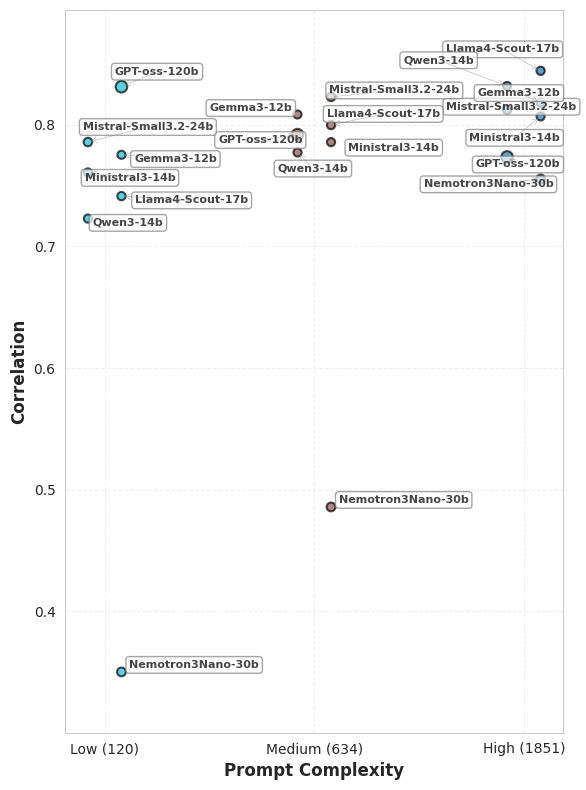

In [198]:
df_filtered = df_metrics[df_metrics["correlation"] > 0.1]


def extract_model_size(model_name: str) -> int:
    """Extract numeric suffix from model name (e.g., 'gpt-4-70b' -> 70)"""
    import re

    match = re.search(r"-(\d+)(?:b)?$", model_name)
    return int(match.group(1)) if match else 50


def model_size_to_bubble_size(size: int) -> float:
    """Convert model size to bubble size"""
    return size / 3 + 30


def map_prompt_to_complexity(token_count: int) -> tuple[int, str]:
    """Map prompt token count to complexity category and label"""
    if token_count <= 200:
        return 0, "Small (120)"
    elif token_count <= 900:
        return 1, "Medium (634)"
    else:
        return 2, "High (1851)"


unique_prompts = df_filtered["prompt"].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_prompts)))
prompt_color_map = {prompt: colors[i] for i, prompt in enumerate(unique_prompts)}

fig, ax = plt.subplots(figsize=(6, 8))

offset_map = {}

for prompt in unique_prompts:
    prompt_data = df_filtered[df_filtered["prompt"] == prompt].sort_values(
        "correlation"
    )

    x_positions = []
    y_values = []
    bubble_sizes = []

    for idx, (row_idx, row) in enumerate(prompt_data.iterrows()):
        x_pos, _ = map_prompt_to_complexity(row["prompt_token_count"])
        model_size = extract_model_size(row["model_name"])

        offset = 0.08 if idx % 2 == 0 else -0.08
        offset_map[row_idx] = offset
        x_positions.append(x_pos + offset)
        y_values.append(row["correlation"])
        bubble_sizes.append(model_size_to_bubble_size(model_size))

    ax.scatter(
        x_positions,
        y_values,
        s=bubble_sizes,
        alpha=0.7,
        color=prompt_color_map[prompt],
        edgecolors="black",
        linewidth=1.5,
    )

texts = []
for row_idx, row in df_filtered.iterrows():
    x_pos, _ = map_prompt_to_complexity(row["prompt_token_count"])
    model_name = row["model_name"]
    offset = offset_map[row_idx]

    text = ax.text(
        x_pos + offset,
        row["correlation"],
        model_name,
        fontsize=8,
        fontweight="bold",
        alpha=0.85,
        bbox=dict(
            boxstyle="round,pad=0.3", facecolor="white", alpha=0.7, edgecolor="gray"
        ),
    )
    texts.append(text)

adjust_text(
    texts,
    arrowprops=dict(arrowstyle="->", color="gray", lw=0.5, alpha=0.5),
    expand_points=(2.5, 2.5),
    expand_text=(2.0, 2.0),
    force_points=(1.0, 1.0),
    force_text=(1.0, 1.0),
    ax=ax,
)

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(["Low (120)", "Medium (634)", "High (1851)"])
ax.set_xlabel("Prompt Complexity", fontsize=12, fontweight="bold")
ax.set_ylabel("Correlation", fontsize=12, fontweight="bold")
ax.grid(True, alpha=0.3, linestyle="--")
ax.set_axisbelow(True)
ax.set_ylim(
    [df_filtered["correlation"].min() - 0.05, df_filtered["correlation"].max() + 0.05]
)

plt.tight_layout()
plt.show()

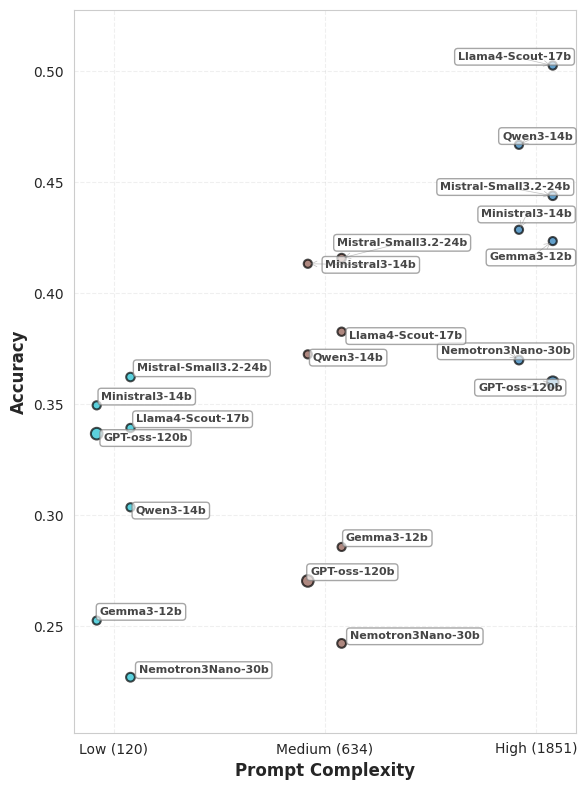

In [ ]:
from evaluation.llm.helpers import calculate_error_rate
from evaluation.llm.interface import compute_metrics_from_llm_data

_dataset_cache: dict[str, np.ndarray] = {}


def _get_labels(dataset_name: str) -> np.ndarray:
    if dataset_name not in _dataset_cache:
        dataset_df = load_dataset(dataset_name)
        _dataset_cache[dataset_name] = dataset_df["label"].to_numpy(dtype=float)
    return _dataset_cache[dataset_name]


all_acc_rows: list[dict] = []

for metric_file in metric_files:
    items = load_metric_files([metric_file])

    for item in items:
        prompt_id = item.get("prompt_id", metric_file.stem)
        prompt = item.get("prompt", "")
        prompt_token_count = item.get("prompt_token_count")
        models = item.get("models", [])

        for model_result in models:
            model_name = model_result.get("model_name")
            if not model_name:
                continue

            dataset_name = model_result.get("dataset", "test")
            predictions = model_result.get("outputs", [])
            if not predictions:
                continue

            labels = _get_labels(dataset_name)
            valid_pairs = [
                (pred, true)
                for pred, true in zip(predictions, labels)
                if pred is not None
            ]
            if not valid_pairs:
                continue

            preds_arr = np.asarray([p for p, _ in valid_pairs], dtype=float)
            labels_arr = np.asarray([lab for _, lab in valid_pairs], dtype=float)

            metrics = compute_metrics_from_llm_data(preds_arr, labels_arr)
            err_rate = calculate_error_rate(predictions, total_samples=len(labels))
            throughput = model_result.get("performance", {}).get("throughput", 0)

            all_acc_rows.append(
                {
                    "model_name": model_name,
                    "prompt": prompt,
                    "prompt_id": prompt_id,
                    "prompt_token_count": prompt_token_count,
                    "dataset": dataset_name,
                    "throughput": throughput,
                    "error_rate": err_rate,
                    "accuracy": metrics["accuracy"],
                }
            )

df_acc = pd.DataFrame(all_acc_rows)

if df_acc.empty:
    print("Skip accuracy scatter plot: no accuracy data available.")
else:
    df_filtered_acc = df_acc[df_acc["accuracy"] > 0.1]

    unique_prompts = df_filtered_acc["prompt"].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_prompts)))
    prompt_color_map = {prompt: colors[i] for i, prompt in enumerate(unique_prompts)}

    fig, ax = plt.subplots(figsize=(6, 8))

    offset_map = {}

    for prompt in unique_prompts:
        prompt_data = df_filtered_acc[df_filtered_acc["prompt"] == prompt].sort_values(
            "accuracy"
        )

        x_positions = []
        y_values = []
        bubble_sizes = []

        for idx, (row_idx, row) in enumerate(prompt_data.iterrows()):
            x_pos, _ = map_prompt_to_complexity(row["prompt_token_count"])
            model_size = extract_model_size(row["model_name"])

            offset = 0.08 if idx % 2 == 0 else -0.08
            offset_map[row_idx] = offset
            x_positions.append(x_pos + offset)
            y_values.append(row["accuracy"])
            bubble_sizes.append(model_size_to_bubble_size(model_size))

        ax.scatter(
            x_positions,
            y_values,
            s=bubble_sizes,
            alpha=0.7,
            color=prompt_color_map[prompt],
            edgecolors="black",
            linewidth=1.5,
        )

    texts = []
    for row_idx, row in df_filtered_acc.iterrows():
        x_pos, _ = map_prompt_to_complexity(row["prompt_token_count"])
        model_name = row["model_name"]
        model_short = model_name.split("/")[-1][:20]
        offset = offset_map[row_idx]

        text = ax.text(
            x_pos + offset,
            row["accuracy"],
            model_short,
            fontsize=8,
            fontweight="bold",
            alpha=0.85,
            bbox=dict(
                boxstyle="round,pad=0.3", facecolor="white", alpha=0.7, edgecolor="gray"
            ),
        )
        texts.append(text)

    adjust_text(
        texts,
        arrowprops=dict(arrowstyle="->", color="gray", lw=0.5, alpha=0.5),
        expand_points=(2.5, 2.5),
        expand_text=(2.0, 2.0),
        force_points=(1.0, 1.0),
        force_text=(1.0, 1.0),
        ax=ax,
    )

    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["Low (120)", "Medium (634)", "High (1851)"])
    ax.set_xlabel("Prompt Complexity", fontsize=12, fontweight="bold")
    ax.set_ylabel("Accuracy", fontsize=12, fontweight="bold")
    ax.grid(True, alpha=0.3, linestyle="--")
    ax.set_axisbelow(True)
    ax.set_ylim(
        [
            df_filtered_acc["accuracy"].min() - 0.025,
            df_filtered_acc["accuracy"].max() + 0.025,
        ]
    )

    plt.tight_layout()
    plt.show()

In [200]:
summary_table = df_metrics.pivot_table(
    index="model_name",
    columns="prompt",
    values=["correlation", "throughput", "error_rate"],
    aggfunc="first",
)

print("Correlation Summary:")
print("=" * 80)
print(summary_table["correlation"].round(3))

print("\n\nThroughput Summary (predictions/sec):")
print("=" * 80)
print(summary_table["throughput"].round(3))

print("\n\nError Rate Summary (%):")
print("=" * 80)
print(summary_table["error_rate"].round(1))

Correlation Summary:
prompt                Rate each text segment on a scale from 0-5, where higher numbers indicate greater visual descriptiveness. Select the **highest applicable rating** found in the segment.\n\n## Rating Scale\n\n**Rating 5** 🏞️ - Full vivid scene\n- Can visualize a complete scene with vivid background, foreground objects, and compelling details (e.g., time of day, lighting, atmospheric conditions)\n- Example: "The sun was setting behind the mountains, casting long shadows over the bustling village square where children played and vendors packed up their stalls."\n\n**Rating 4** 🏞️ - Full scene with details OR detailed character\n- **Option A (Scene)**: Can visualize a full scene with multiple elements - must have at least 3 of:\n  1. Background/surroundings\n  2. Action/main scene\n  3. Describable character(s)\n  4. Other visual details (each distinct detail counts separately)\n  - Example: "A river flowed through the meadow, with a few trees scattered along its 

In [201]:
overall_ranking = (
    df_metrics.groupby("model_name")
    .agg({"correlation": "mean", "throughput": "mean", "error_rate": "mean"})
    .round(3)
    .sort_values("correlation", ascending=False)
)

print("\nOverall Model Rankings (Average across all prompts):")
print("=" * 80)
print(overall_ranking)


Overall Model Rankings (Average across all prompts):
                      correlation  throughput  error_rate
model_name                                               
Mistral-Small3.2-24b        0.807       8.991       0.000
Gemma3-12b                  0.801       6.092       0.000
GPT-oss-120b                0.799       0.518       0.255
Llama4-Scout-17b            0.795       1.387       0.000
Ministral3-14b              0.785      13.522       0.000
Qwen3-14b                   0.777      12.119       0.000
Nemotron3Nano-30b           0.530       5.532       0.340


## Multiple Models Comparison

Load metrics and compare multiple LLM models across different prompts.

In [202]:
# Load all metric files
metric_files = sorted(METRICS_DIR.glob("*.json"))
items = load_metric_files(metric_files)

print(f"Loaded {len(items)} metric configurations")

Loaded 3 metric configurations


### Configuration Selection

Select which prompt configuration to evaluate. See available options below.

In [203]:
config_names = [item.get("prompt_id", f"config_{i}") for i, item in enumerate(items)]

print(f"Available configurations ({len(config_names)}):")
for idx, name in enumerate(config_names):
    print(f"  {idx}: {name}")

Available configurations (3):
  0: config_0
  1: config_1
  2: config_2


In [204]:
SELECTED_CONFIG_IDX = 1
print(f"Selected configuration: {config_names[SELECTED_CONFIG_IDX]}")

Selected configuration: config_1


### Load and Convert Model Metrics

Convert LLM model metrics to standardized evaluation format.

In [193]:
# Load training and test data
df_train, df_test = load_train_test_data(DATA_DIR)

# Convert metric items to score data format
score_data = to_llm_score_data(items, df_train, df_test)

# Filter for selected configuration
filtered_score_data = [sd for sd in score_data if sd.config_id == SELECTED_CONFIG_IDX]

print(f"Configuration: Config {SELECTED_CONFIG_IDX}")
print(f"Models in this configuration: {len(filtered_score_data)}")
for sd in filtered_score_data:
    print(f"  - {sd.model_name}")

Configuration: Config 1
Models in this configuration: 7
  - gpt-oss-120b
  - mistral-small3.2-24b
  - llama4-scout-17b
  - ministral3-14b
  - gemma3-12b
  - qwen3-14b
  - nemotron3nano-30b


In [179]:
# Create core visualization models for selected configuration
multiple_models = []
for sd in filtered_score_data:
    train_outputs = (
        to_int_0_5(sd.train_scores)
        if sd.train_scores is not None and sd.train_scores.size > 0
        else None
    )
    test_outputs = (
        to_int_0_5(sd.test_scores)
        if sd.test_scores is not None and sd.test_scores.size > 0
        else None
    )

    if train_outputs is not None or test_outputs is not None:
        converted = llm_metrics_to_core(
            predictions=train_outputs,
            labels=sd.y_train if train_outputs is not None else None,
            test_predictions=test_outputs,
            test_labels=sd.y_test if test_outputs is not None else None,
            model_name=sd.model_name,
        )
        multiple_models.append(converted)

print(
    f"Loaded {len(multiple_models)} model(s) from configuration {SELECTED_CONFIG_IDX}"
)
for m in multiple_models:
    train_status = "✓" if m.train is not None else "✗"
    test_status = "✓" if m.test is not None else "✗"
    print(f"  - {m.model} [Train: {train_status}, Test: {test_status}]")

Loaded 1 model(s) from configuration 1
  - Mistral-Small3.2-24b [Train: ✓, Test: ✗]


### Per-label metrics and model comparison plots

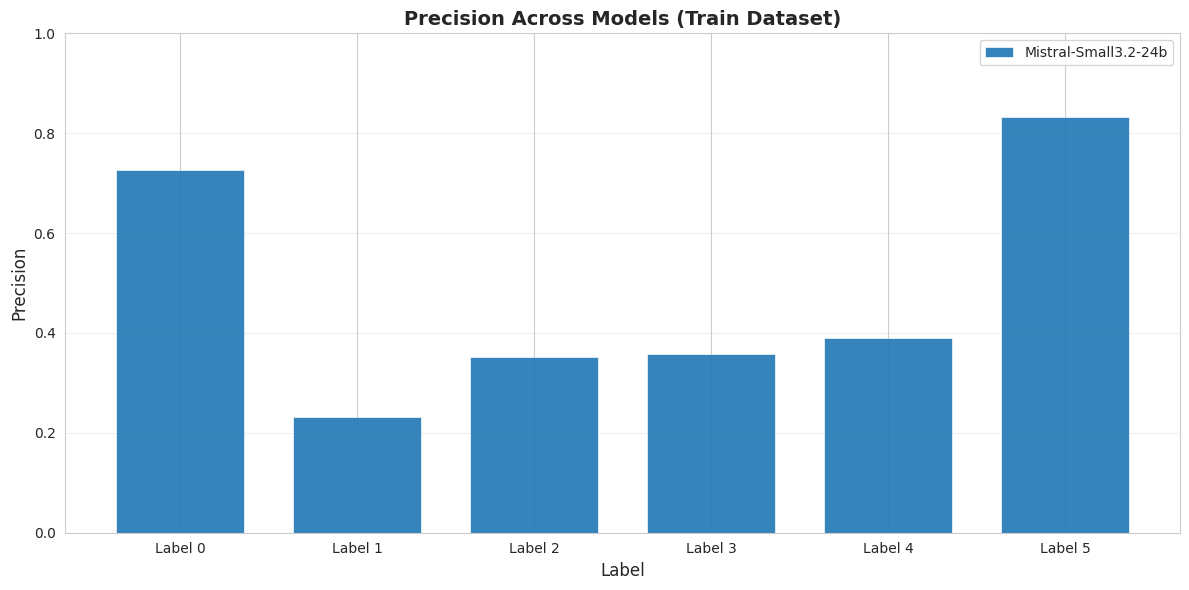

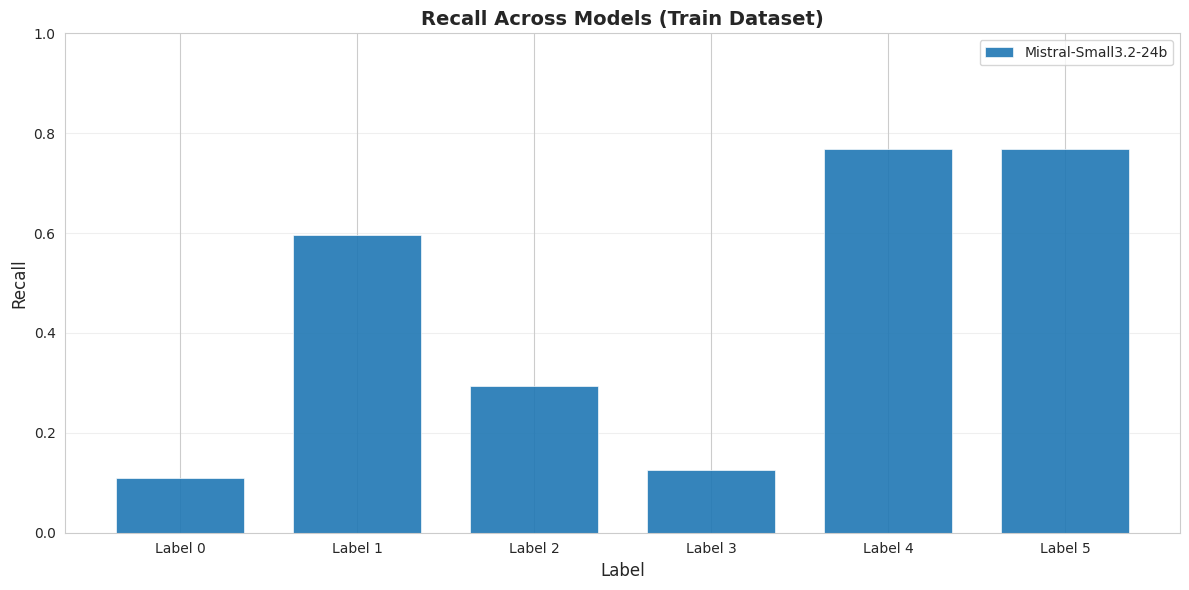

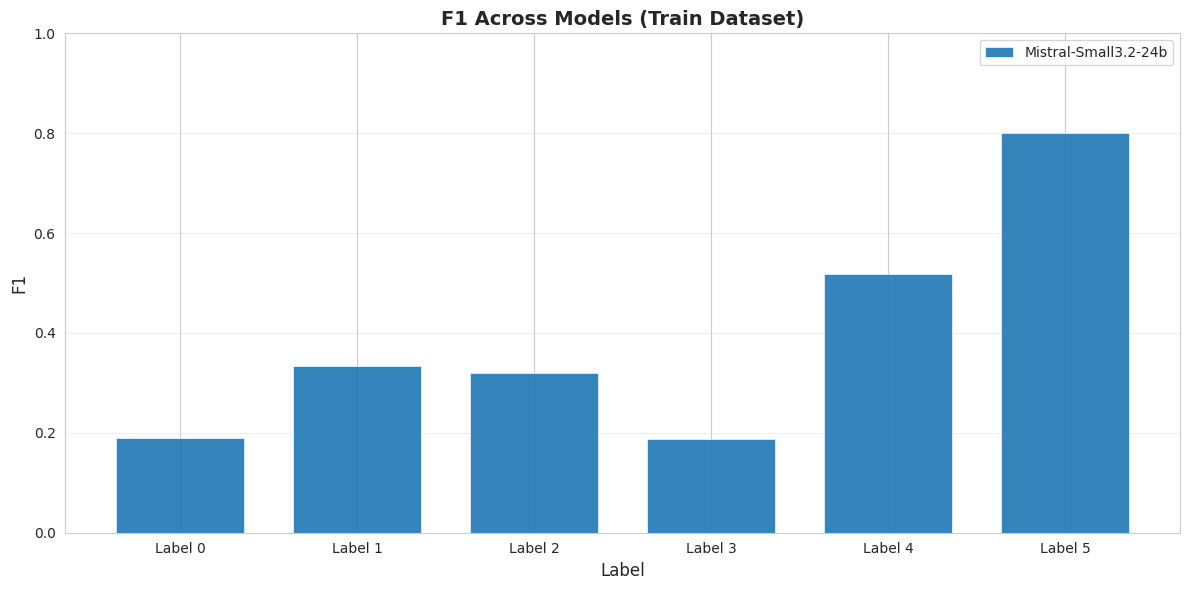

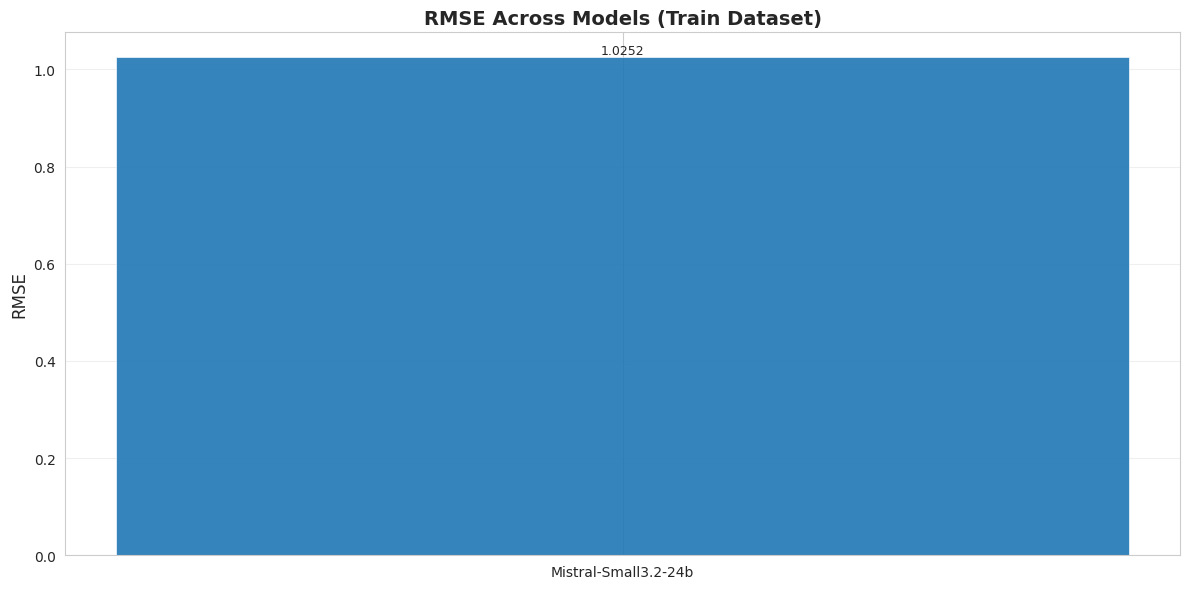

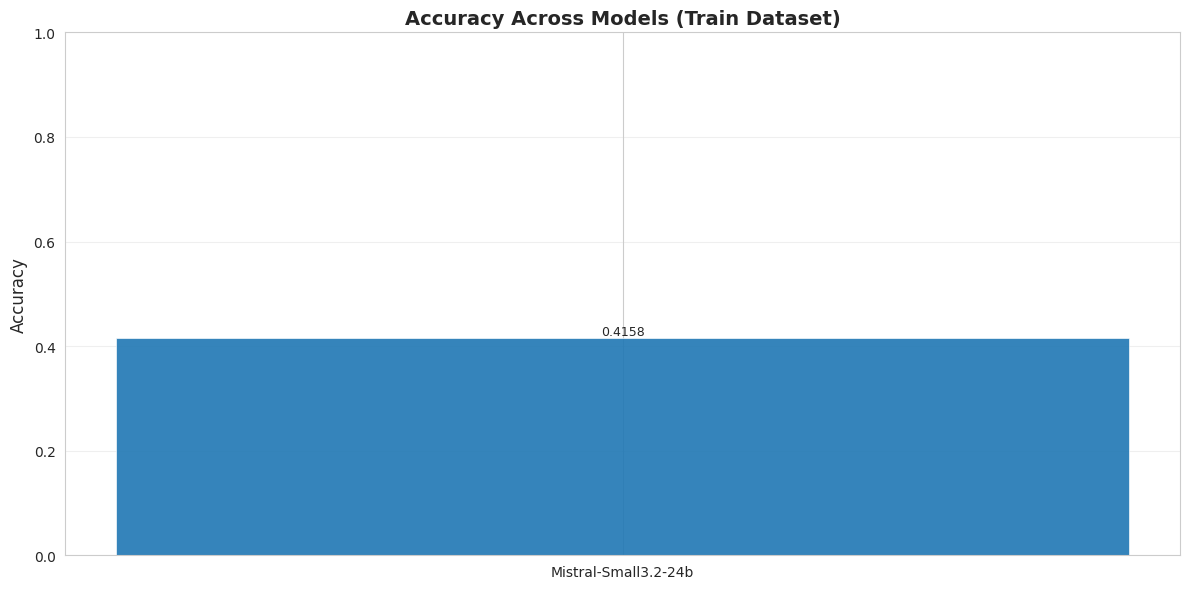

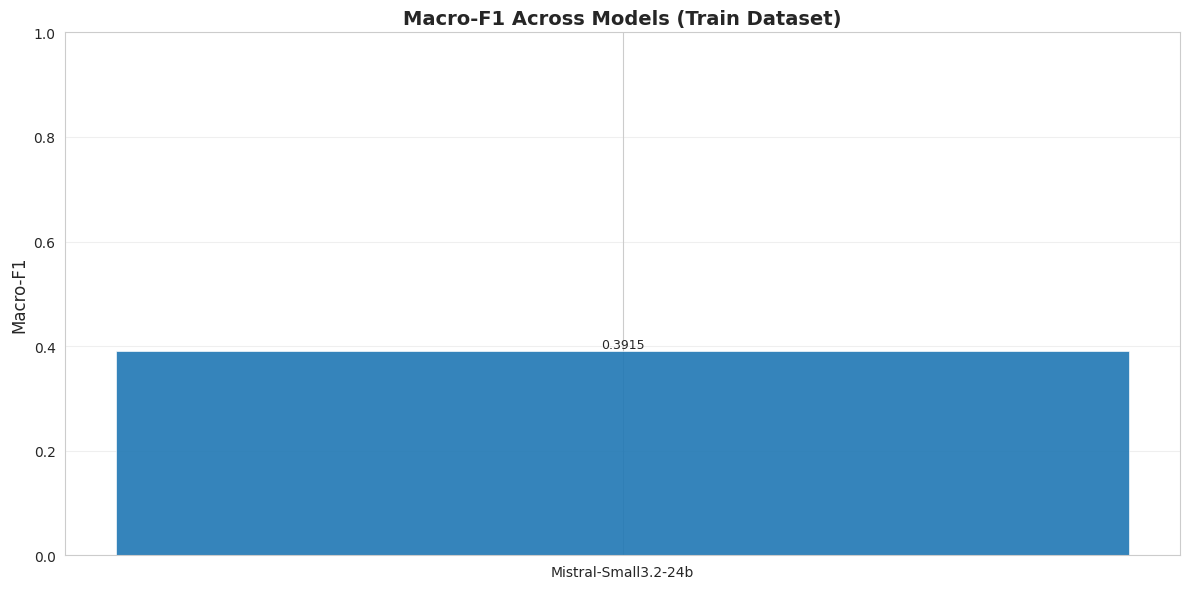

In [180]:
if multiple_models:
    vis_all_models_plots(multiple_models, "train")

### Summary comparison table

In [181]:
if multiple_models:
    model_names = [m.model for m in multiple_models]
    model_groups, show_large_variants = get_llm_model_groups(model_names)
    df_metrics_summary = vis_all_models_tables(
        multiple_models,
        ["RMSE", "Acc"],
        ["Train", "Test"],
        model_groups,
        show_large_variants,
    )
    latex_table = format_metrics_for_latex(df_metrics_summary)
    print(latex_table)

,Model,Train RMSE,Test RMSE,Train Acc,Test Acc
0,Mistral-Small3.2-24b,1.0252,,0.4158,


\begin{tabular}{rrrrr}
\toprule
\textbf{Model} & \textbf{Train RMSE} & \textbf{Test RMSE} & \textbf{Train Acc} & \textbf{Test Acc} \\
\midrule
Mistral-Small3.2-24b & \textbf{1.0252} &  & \textbf{0.4158} &  \\
\bottomrule
\end{tabular}



/home/terra/Projects/vis-desc/modules/lab/src/evaluation/core.py:921: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{1.0252}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  
/home/terra/Projects/vis-desc/modules/lab/src/evaluation/core.py:921: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{0.4158}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  
